## init

In [1]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils,
    examples as ex,
    sneaky_matrix as sneaky
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

from typing import *

import matplotlib.pyplot as plt
%matplotlib inline

import mars



def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}'
    if ex.prune_eps is not None:
        filename += f'-peps{ex.prune_eps}'
    filename += '.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4


# thing go bbrrr

|======== Timed report ========
| reduce sparse              :    3332.27ms  (3332.267ms per; #1)
| vineyard.get_state_at_point:      64.42ms  ( 0.004ms per; #16296)
| reduce_vine: ordering      :   95479.48ms  ( 5.859ms per; #16296)
| from sparse                :      48.94ms  ( 8.157ms per; #6)
| mars.reduce_vine           :  964594.85ms  (59.192ms per; #16296)
| reduce_vine.almost-all     :  973290.71ms  (59.726ms per; #16296)
|==============================


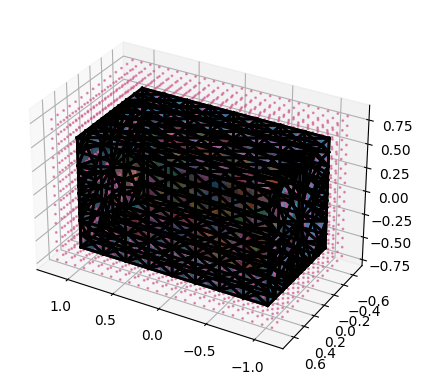

In [141]:
example = ex.shoebox_3


###################

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

faces = []
swaps = []
class vineyard2(vin.vineyard):
  def get_point_key(self, point: np.ndarray):
    return gridd.cell_of(point)
  
  def prune(self, s1: cplx.simplex, s2: cplx.simplex, old_state, new_state):
    swaps.append((s1, s2, old_state, new_state))

    if s1.dim() == example.medial_axis:
      per_1 = vin.compute_persistence(s1, old_state.ordering, old_state.R)
      per_2 = vin.compute_persistence(s2, new_state.ordering, new_state.R)
      if per_1 < 0.01 or per_2 < 0.01:
        return True

    return vin.prune_euclidean(our_complex, s1, s2, old_state.point, new_state.point, example.prune_eps)

  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, old_state, new_state):
    super().on_faustian(s1, s2, old_state.point, new_state.point)
    if s1.dim() == example.medial_axis:
      c1 = gridd.cell_of(old_state.point)
      c2 = gridd.cell_of(new_state.point)
      faces.append(gridd.dual_face(c1, c2))

v = vineyard2(our_complex)

n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    v.reduce(center_point)
  else:
    old_point = gridd.coordinate(old_cell)
    old_state = v.get_state_at_point(old_point)
    new_point = gridd.coordinate(new_cell)
    v.reduce_vine(old_state, new_point)

gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

ourplot.plot_vineyard_results(our_complex, gridd, faces, CameraOpt(azim=120, elev=30))
export_obj(example, our_complex, faces)

# newest pruning

/var/folders/s5/np01y3nn239b1wb3m4fgt90m0000gn/T/ipykernel_15416/2595536801.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


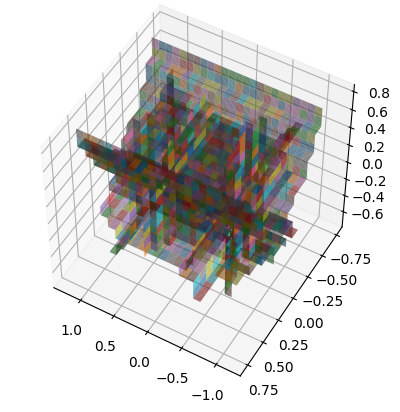

In [149]:
import math
med_ax_dim = 1
euc_prune_param = 3.9
persistence_prune = True
pers_euc = 1*euc_prune_param
pers_prune_eps = .01 # default 0.01
##############################
# for eps in [5, 9.98 * 1 / math.sqrt(2), 10 / math.sqrt(2)]:
ffaces = []
for (s1, s2, a, b) in swaps:
  if vin.prune_euclidean(our_complex, s1, s2, a.point, b.point, euc_prune_param):
    continue
  # smarter prune? 
  if s1.dim() == med_ax_dim and persistence_prune and vin.prune_euclidean(our_complex, s1, s2, a.point, b.point, pers_euc):
      per_1 = vin.compute_persistence(s1, a.ordering, a.R)
      per_2 = vin.compute_persistence(s2, b.ordering, b.R)
      if per_1 < pers_prune_eps or per_2 < pers_prune_eps:
        continue
  if s1.dim() == med_ax_dim:
    c1 = gridd.cell_of(a.point)
    c2 = gridd.cell_of(b.point)
    ffaces.append(gridd.dual_face(c1, c2))
fig, ax = ourplot.plot_vineyard_results(our_complex, gridd, ffaces, CameraOpt(azim=120, elev=50), skip_grid=True, skip_cube=True)
fig.show()
export_obj(example, our_complex, ffaces)